In [53]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [197]:
# import pandas as pd

# df = pd.read_excel('Superstore.xls')
headers=['Interval','Timestamp','Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)', 'Precipitation (mm)']
df = pd.read_csv ('sani_clean.csv', names=headers)#, index_col='Timestamp', parse_dates = True)
df=df[1:]

In [198]:
df.head()

,Interval,Timestamp,Flume Depth (mm),AV Flow (L/s),Flume Flow (L/s),Precipitation (mm)
1,15 Min,2021-04-01 0:15,14.16,0.4,0.22,0
2,15 Min,2021-04-01 0:30,14.95,0.24,0.29,0
3,15 Min,2021-04-01 0:45,14.88,0.15,0.21,0
4,15 Min,2021-04-01 1:00,13.1,0.17,0.21,0
5,15 Min,2021-04-01 1:15,13.96,0.23,0.21,0


In [199]:
df.columns

Index(['Interval', 'Timestamp', 'Flume Depth (mm)', 'AV Flow (L/s)',
       'Flume Flow (L/s)', 'Precipitation (mm)'],
      dtype='object')

In [200]:
# flow = df[['Timestamp','AV Flow (L/s)']]

flow = df[['Timestamp','AV Flow (L/s)']]

In [201]:
flow.head(1)

,Timestamp,AV Flow (L/s)
1,2021-04-01 0:15,0.4


In [202]:

flow.isnull().sum()

Timestamp        0
AV Flow (L/s)    0
dtype: int64

In [203]:
# flow = flow.set_index('Timestamp')
# flow['Timestamp'] = pd.to_datetime(flow['Timestamp'])
flow['AV Flow (L/s)'] = flow['AV Flow (L/s)'].astype(float)
flow

,Timestamp,AV Flow (L/s)
1,2021-04-01 0:15,0.40
2,2021-04-01 0:30,0.24
3,2021-04-01 0:45,0.15
4,2021-04-01 1:00,0.17
5,2021-04-01 1:15,0.23
...,...,...
994,2021-04-11 8:30,0.66
995,2021-04-11 8:45,0.57
996,2021-04-11 9:00,0.42
997,2021-04-11 9:15,0.52


In [204]:
# y=flow['AV Flow (L/s)'].astype('float')

In [205]:
flow['Timestamp'] = pd.to_datetime(flow['Timestamp'])

In [206]:
y = flow.resample('H', on = 'Timestamp').mean()

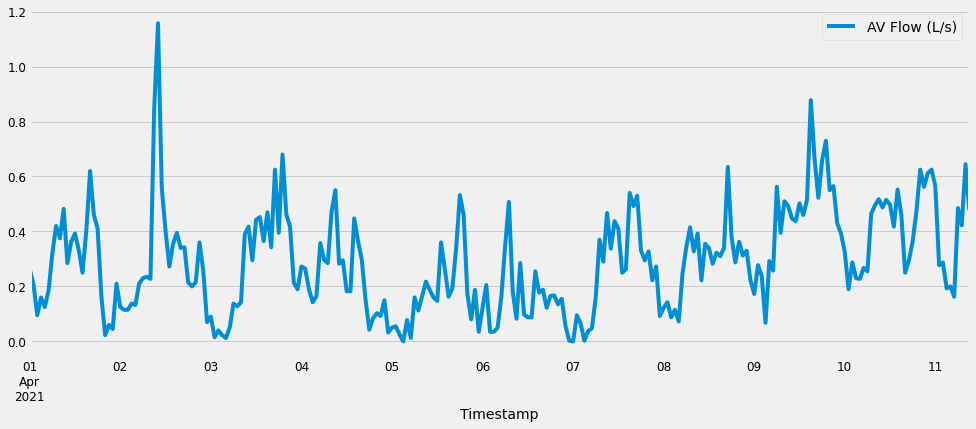

In [207]:
import matplotlib.pyplot as plt
y.plot(figsize=(15, 6))
plt.show()

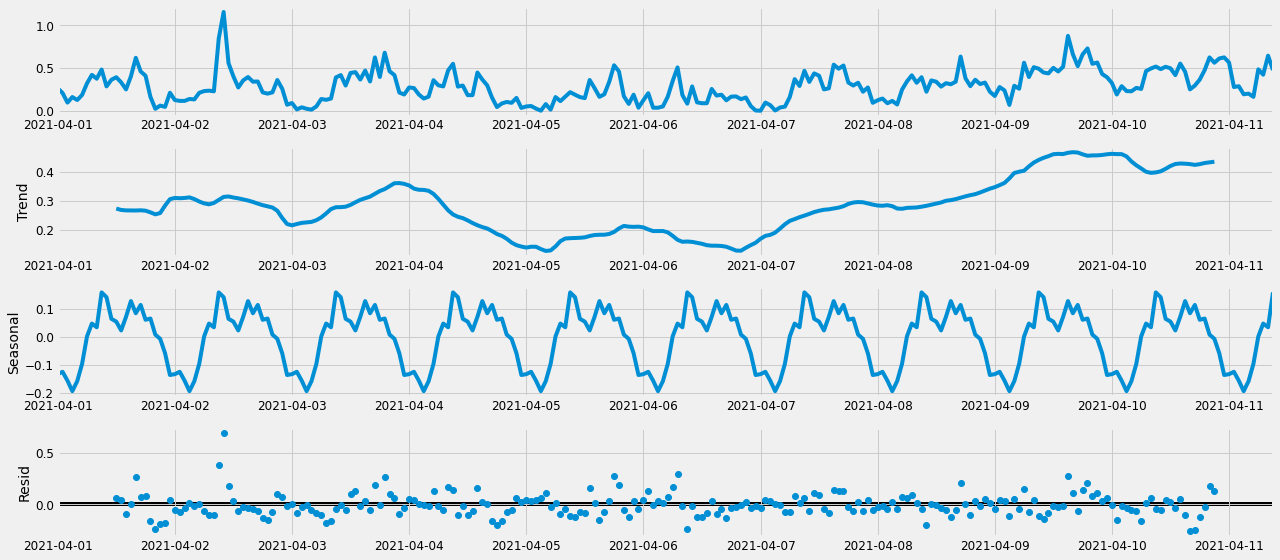

In [208]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [209]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [210]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        
        except:
            continue
            
results = mod.fit(disp=0)

print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))


        

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-248.06393168575363


In [211]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6783      0.038     17.903      0.000       0.604       0.753
ma.L1         -0.9650      0.028    -35.038      0.000      -1.019      -0.911
ar.S.L12      -0.0499      0.086     -0.577      0.564      -0.219       0.119
ma.S.L12      -1.1136      0.110    -10.107      0.000      -1.330      -0.898
sigma2         0.0130      0.002      5.992      0.000       0.009       0.017


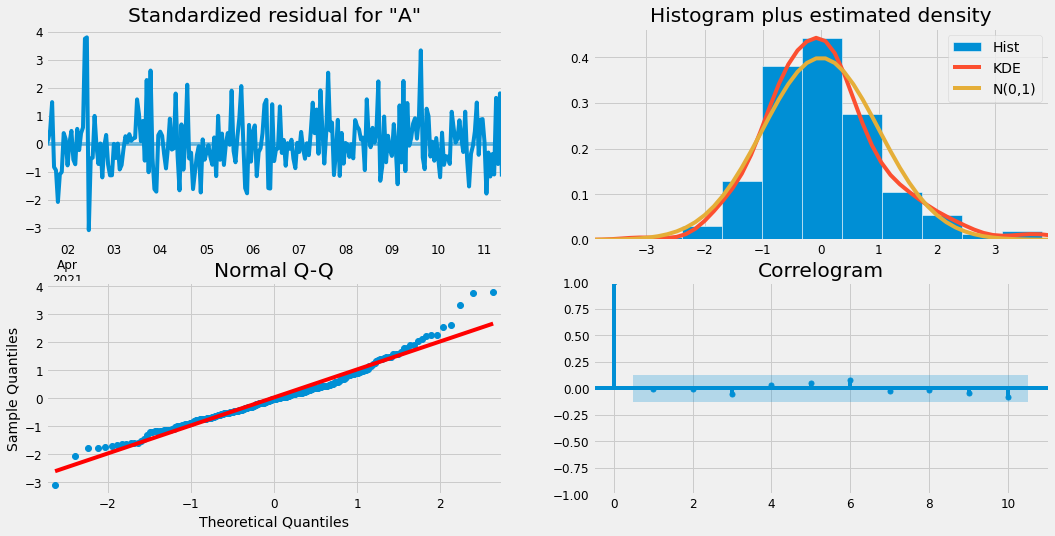

In [212]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

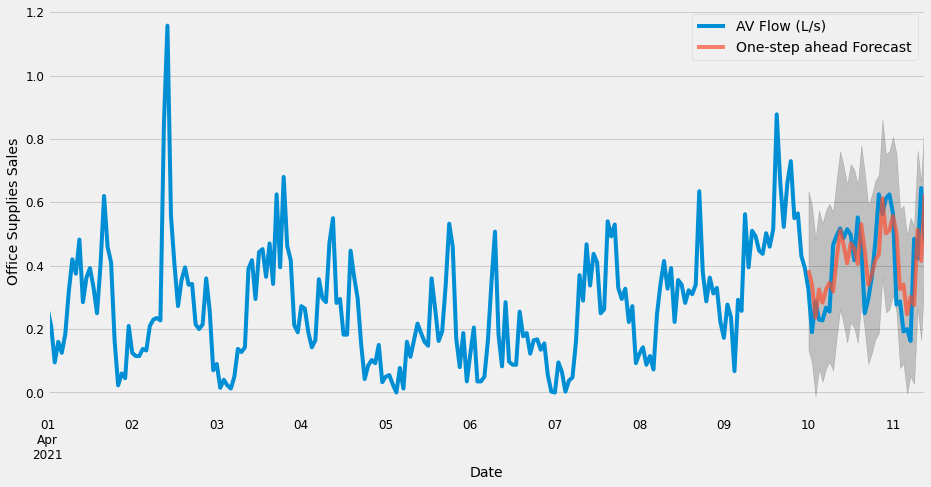

In [216]:
pred = results.get_prediction(start=pd.to_datetime('2021-04-10'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2021-04':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

In [51]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 66980.62


In [52]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 258.81


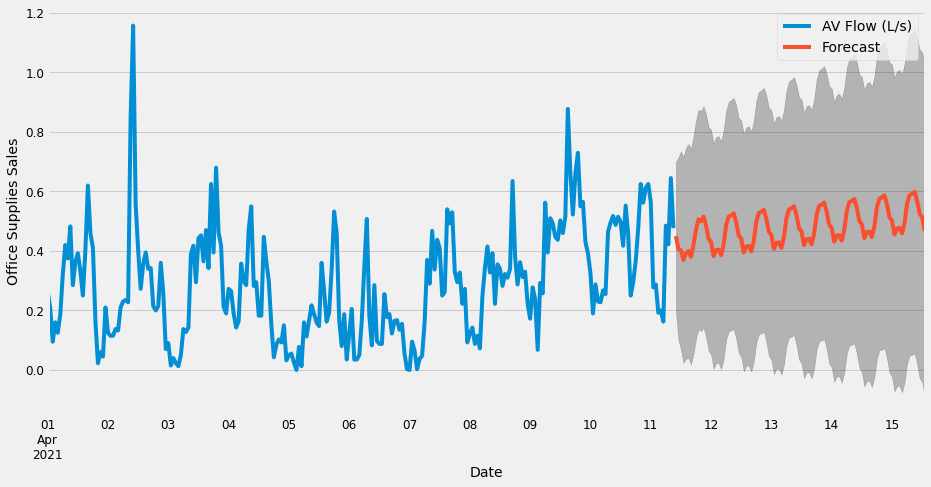

In [217]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

In [55]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [56]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


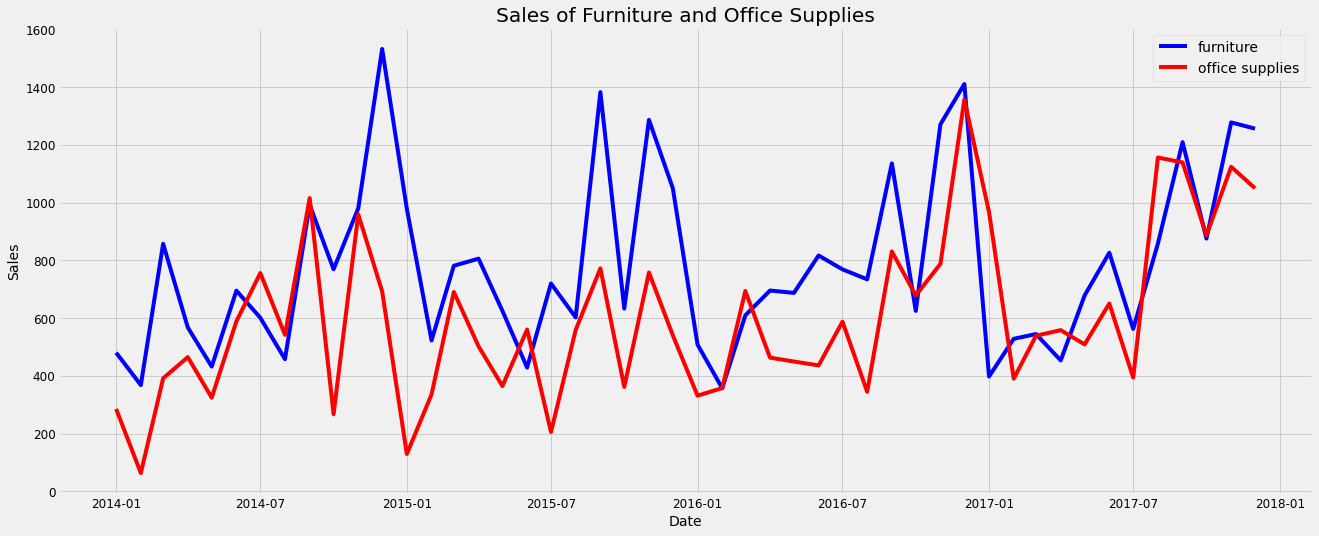

In [57]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [61]:
first_date = store.iloc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])),'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -14.4894
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1730    0.00019162       77.3825           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128        1730.3    0.00142507       90.3809   1.467e-05       0.001      209  LS failed, Hessian reset 
     150        1730.4    0.00015405       78.4678   2.735e-06       0.001      266  LS failed, Hessian reset 
     199       1730.41   1.98682e-06       77.1865       3.428      0.3428      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1730.41    8.1228e-09       64.1834     0.06442     0.06442      343   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


<Figure size 1296x432 with 0 Axes>

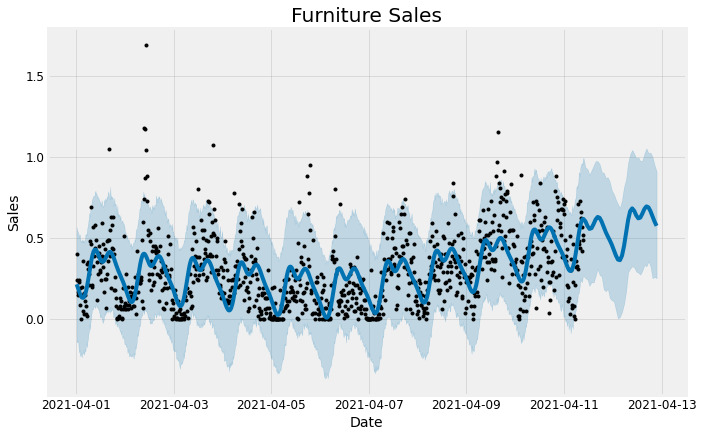

In [219]:
from fbprophet import Prophet
# furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
# furniture_model = Prophet(interval_width=0.95)
# furniture_model.fit(furniture)
flow = flow.rename(columns={'Timestamp': 'ds', 'AV Flow (L/s)': 'y'})
flow_model = Prophet(interval_width=0.95)
flow_model.fit(flow)
# furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
# furniture_forecast = furniture_model.predict(furniture_forecast)
flow_forecast = flow_model.make_future_dataframe(periods=36, freq='H')
flow_forecast = flow_model.predict(flow_forecast)
plt.figure(figsize=(18, 6))
flow_model.plot(flow_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

In [64]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]

office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()

merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names

merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,289.704734,775.690948,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,223.510909,687.534195,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,456.639986,954.963063,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,401.947595,857.196680,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,314.302405,807.042763,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


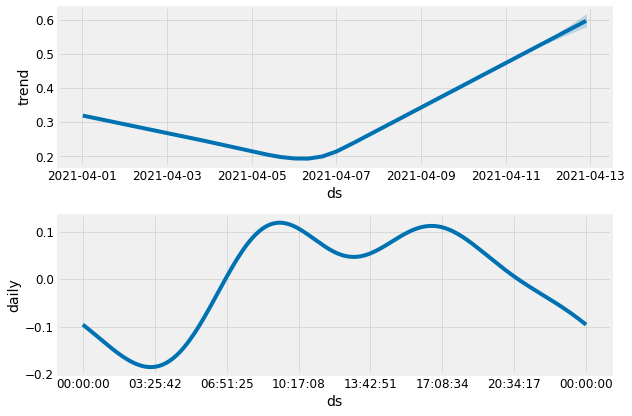

In [221]:
flow_model.plot_components(flow_forecast);

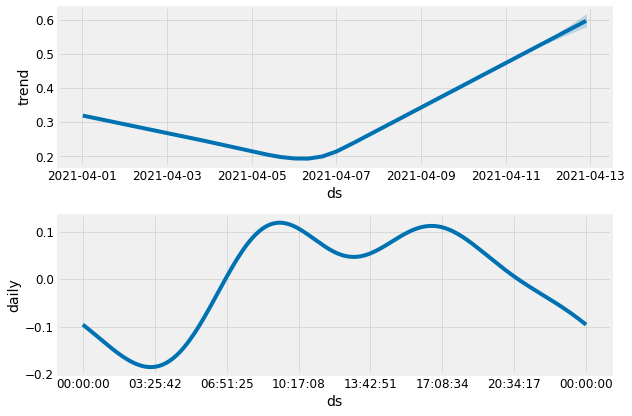

In [222]:
flow_model.plot_components(flow_forecast);